<a href="https://colab.research.google.com/github/drscotthawley/DLAIE/blob/main/Lessons/06b_SkipsResNetsUNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Be the Change": Skip Connections, ResNets and U-Nets

It is a common observation in numerical modeling that if you can predict the *change* in something rather than the thing itself, you can often get much more accurate results (than predicting the entire thing).

**Table of Contents:**

A. Residual Skips, ResNets

---Exercise---
   
B. Concatenative Skips, U-Nets


# A. Residual Skips, ResNets
This change is often called the "residual", and it inspired a whole set of architectures based on "skip residual" connections, the first and most famous being the [ResNet](https://ieeexplore.ieee.org/document/7780459) ([arXiv link](https://arxiv.org/abs/1512.03385)) family of image-processing networks. Despite dating back to 2015, ResNets are still in heavy use today, and their key insights are repeated even in sophisticated modern LLMs.  

The idea behind ResNet is to use a "skip connection" around a couple layers of network operations, and then *add* the output of those layers to what's connected via the skip. Thus the neural network layers bypassed by the skip can focus on computing the *change* or "residual" rather than the "thing itself":

## ResNet "Blocks":  Additive / "Residual" Connections
![residual picture](https://miro.medium.com/max/683/0*0r0vS8myiqyOb79L.jpg)

*Source: [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf)*

In the above figure, the "skip residual" connection is the big curved arrow on the right.

That "resnet block" shown above is then used *repeatedly* throughout the network architecture. ResNets can be made using various numbers of layers. One variation that has some into standard usage is ResNet34, which uses 34 resnet blocks.  In the following diagram, ResNet34 (on the right) is compared to the older VGG model (on the left) and a similar model (in the middle) which has no residual connections.  

**Model architecture comparison:**

Left: VGG ("standard ConvNet"), Middle: Deep CNN w/o residuals, Left: ResNet

![resnet_bigger](https://i.imgur.com/mbi6ktD.png)

It was found that ResNets massively outperformed previous approaches. The intuitions about residuals (i.e. "predicting the change rather than the thing itself") allowing for higher accuracy, and the idea that skip connections allowing information to "propagate across the network more efficiently" seem like plausible reasons why ResNets work well, however there is another reason related to the process of gradient descent:

## Residuals Smooth the Loss surface

It turns out that skip connections can remove wiggles in the loss surface, allowing it to be more smooth and thus allowing gradient descent methods to accelerate converence and not get stuck in local minima:
![loss surface image](https://miro.medium.com/max/2000/1*ME5zYSkdsQT3pEIDDGE1Fg.png)

*Source: ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/pdf/1712.09913.pdf)

## Let's see it in code
Let's compare this to our earlier CNN/ConvNet, in code.  We'll reuse a lot of the code from the ConvNets lesson, and focus on the CIFAR100 dataset since it's "hard". ;-)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.v2 import CutMix, MixUp, RandomChoice
import wandb
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

# block annoying warning I don't want you to worry about
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic.main")

In [2]:
# check that there's more than just the CPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
if device==torch.device('cpu'): print("You should probably restart this with a GPU. It will be slow otherwise.")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [3]:
DATASETS = {
    'MNIST': {
        'dataset_class': torchvision.datasets.MNIST,
        'mean': (0.1307,), 'std': (0.3081,),
        'description': '28x28 grayscale handwritten digits (0-9)'
    },
    'FashionMNIST': {
        'dataset_class': torchvision.datasets.FashionMNIST,
        'mean': (0.2860,), 'std': (0.3530,),
        'description': '28x28 grayscale fashion items (10 classes)'
    },
    'CIFAR10': {
        'dataset_class': torchvision.datasets.CIFAR10,
        'mean': (0.4914, 0.4822, 0.4465), 'std': (0.2023, 0.1994, 0.2010),
        'description': '32x32 color images (10 classes: planes, cars, etc.)'
    },
    'CIFAR100': {
        'dataset_class': torchvision.datasets.CIFAR100,
        'mean': (0.5071, 0.4867, 0.4408), 'std': (0.2675, 0.2565, 0.2761),
        'description': '32x32 color images (100 classes)'
    }
}

print("Available datasets:")
for name, info in DATASETS.items():
    print(f"  {name}: {info['description']}")


# Also let's let the user choose different activation functions, which will be implemented globally:
activations = { 'ReLU': nn.ReLU(), 'GELU': nn.GELU(),  'SiLU': nn.SiLU(), 'LeakyReLU': nn.LeakyReLU(0.01)}
print("\nAvailable activations:", activations.keys())



Available datasets:
  MNIST: 28x28 grayscale handwritten digits (0-9)
  FashionMNIST: 28x28 grayscale fashion items (10 classes)
  CIFAR10: 32x32 color images (10 classes: planes, cars, etc.)
  CIFAR100: 32x32 color images (100 classes)

Available activations: dict_keys(['ReLU', 'GELU', 'SiLU', 'LeakyReLU'])


In [4]:
#### Your choices for dataset & activation functions
DATASET_NAME = 'CIFAR100'  # Change this to 'FashionMNIST', 'CIFAR10', or 'CIFAR100'
ACTIVATION_NAME = 'SiLU'  # Options: 'ReLU', 'GELU', 'SiLU', 'LeakyReLU'

ACTIVATION = activations[ACTIVATION_NAME]

print(f"\nUsing: {DATASET_NAME}")
print(f"Activation function: {ACTIVATION_NAME}")


Using: CIFAR100
Activation function: SiLU


In [5]:
def get_dataset_info(dataset_name):
    """Get dataset configuration and sample to determine properties."""
    config = DATASETS[dataset_name]
    basic_transform = transforms.Compose([transforms.ToTensor()])
    temp_dataset = config['dataset_class'](root='./data', train=True, download=True, transform=basic_transform)
    sample_img, _ = temp_dataset[0]

    return {
        'config': config,
        'num_channels': sample_img.shape[0],
        'img_height': sample_img.shape[1],
        'img_width': sample_img.shape[2],
        'num_classes': len(temp_dataset.classes),
        'class_names': temp_dataset.classes
    }

dataset_info = get_dataset_info(DATASET_NAME)
DATASET_INFO = dataset_info

print(f"\nDataset Properties:")
print(f"  Image size: {dataset_info['num_channels']}x{dataset_info['img_height']}x{dataset_info['img_width']}")
print(f"  Number of classes: {dataset_info['num_classes']}")
print(f"  Classes: {dataset_info['class_names'][:10]}...")  # Show first 10 classes

num_classes = dataset_info['num_classes']
cutmix = CutMix(num_classes=num_classes, alpha=0.2)
mixup = MixUp(num_classes=num_classes, alpha=0.2)
cutmix_or_mixup = mixup # RandomChoice([cutmix, mixup])


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # do some data augmentation when training
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(dataset_info['config']['mean'], dataset_info['config']['std'])
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(dataset_info['config']['mean'], dataset_info['config']['std'])
])

train_dataset = dataset_info['config']['dataset_class'](root='./data', train=True, download=False, transform=train_transform)
val_dataset = dataset_info['config']['dataset_class'](root='./data', train=False, download=False, transform=val_transform)

batch_size = 128 # could make this bigger
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)

print(f"\nDataset loaded:")
print(f"  Training samples: {len(train_dataset):,}")
print(f"  Val samples: {len(val_dataset):,}")


Dataset Properties:
  Image size: 3x32x32
  Number of classes: 100
  Classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']...

Dataset loaded:
  Training samples: 50,000
  Val samples: 10,000


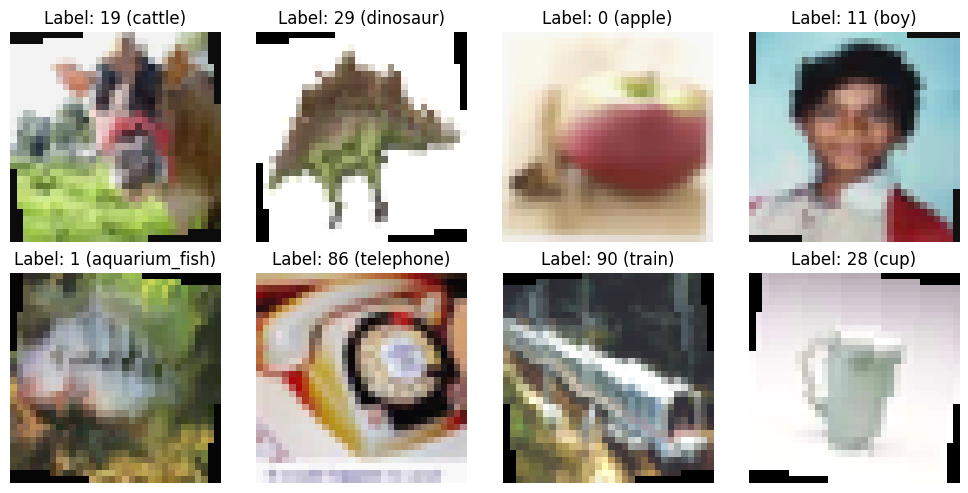

In [6]:
def plot_samples(dataset, dataset_info, num_samples=8):
    """Visualize some sample images"""
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    axes = axes.ravel()
    mean, std = dataset_info['config']['mean'], dataset_info['config']['std']

    for i in range(num_samples):
        img, label = dataset[i]

        if len(mean) == 1:  # Grayscale
            img_denorm = img.squeeze() * std[0] + mean[0]
            axes[i].imshow(img_denorm, cmap='gray')
        else:  # Color
            img_denorm = img.clone()
            for c in range(len(mean)):
                img_denorm[c] = img_denorm[c] * std[c] + mean[c]
            img_denorm = torch.clamp(img_denorm, 0, 1).permute(1, 2, 0)  # (C,H,W) -> (H,W,C)
            axes[i].imshow(img_denorm)

        axes[i].set_title(f'Label: {label} ({dataset_info["class_names"][label]})')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_samples(train_dataset, dataset_info)

## Revised Neural Network Architecture

To really see the benefits of the ResNet approach, we need to dispense with the shallow, simple ConvNets that we had before, and go "deeper" in terms of number of layers.  

---

As an exercise, go back to the previous lesson on ConvNets and (try to) train the CNN on CIFAR100, then come back. How did it do?

---

#### Splitting Downsampling & Learned Filters
Earlier we used a `stride` of 2 which had the effect of both downsampling and allowing for learnable filtering. But the plus sign "+" in the skip residual means that we can only add tensors with the same shapes. So for this lesson, we're going to separate the downsampling from the learnable filtering.  We'll downsample with "average pooling", and then use convolutions with `stride=1` (and  `padding=1`) to keep the output the same shape as in the input.

#### Adding Batch Normalization

Another key ingredient of the ResNet approach with influence to the modern day is Batch Normalization or "Batch Norm" (although nowadays it's replaced by related "Layer Norm" or "Group Norm", but similar in principle). Our rectifier-like activation functions have a tendency to shift the data distribution from being zero-mean to having some net positive bias, which can make it harder to learn.  So what we do is periodically "re-whiten" the distribution of the data $x$ for each batch, i.e. something like this:

$$ x :=  { x - \mu_B \over \sigma_B } $$

where $\mu_B$ and $\sigma_B$ are the batch mean and standard deviation, respectively.  However, what's actually done in practice is a bit more expressive:

$$ x := \gamma \cdot { x - \mu_B \over \sqrt{\sigma_B^2 + \epsilon} } + \beta $$

where $\gamma$ and $\beta$ are learnable parameters that allow the network to scale and shift the normalized values if needed (so the network can effectively "undo" the normalization if that turns out to be beneficial), and we combine the variance $\sigma_B^2$ with a small constant $\epsilon$ for numerical stability.

There is a computational cost for doing the Batch Norm, but it pays off in big ways, as we'll see.

#### And Now for the Code!
We're now ready to see the code for our replacement for the simple CNN from before.  We're going to build it out of "Residual Blocks" as in the diagram above. And we'll design it so that, for the sake of comparison, we can turn the skip connections and Batch Norm on or off:

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_skip=True, use_bn=True):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=not use_bn)
        self.bn1 = nn.BatchNorm2d(channels) if use_bn else nn.Identity()
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=not use_bn)
        self.bn2 = nn.BatchNorm2d(channels) if use_bn else nn.Identity()
        self.use_skip = use_skip

    def forward(self, x):
        if self.use_skip: x0 = x
        out = ACTIVATION(self.bn1(self.conv1(x)))
        out = F.dropout(out, 0.4, training=self.training)
        out = self.bn2(self.conv2(out))
        if self.use_skip: out = out + x0
        return ACTIVATION(out)

In [8]:
class FlexibleCNN(nn.Module):
    def __init__(self, dataset_info=DATASET_INFO, base_channels=32, blocks_per_level=4, use_skips=False, use_bn=True):
        super().__init__()

        # Initial conv
        self.conv1 = nn.Conv2d(dataset_info['num_channels'], base_channels, 3, padding=1, bias=not use_bn)
        self.bn1 = nn.BatchNorm2d(base_channels) if use_bn else nn.Identity()

        # Build levels dynamically
        self.levels = nn.ModuleList()
        channels = [base_channels, base_channels*2, base_channels*4]

        for level_idx, ch in enumerate(channels):
            level_blocks = nn.ModuleList()
            for block_idx in range(blocks_per_level):
                level_blocks.append(ResidualBlock(ch, use_skips, use_bn))
            self.levels.append(level_blocks)

        # Transition layers
        self.transitions = nn.ModuleList([
            nn.Conv2d(base_channels, base_channels*2, 1, bias=not use_bn),
            nn.Conv2d(base_channels*2, base_channels*4, 1, bias=not use_bn)
        ])

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(base_channels*4, dataset_info['num_classes'])

    def forward(self, x):
        x = ACTIVATION(self.bn1(self.conv1(x)))

        # Level 1 blocks
        for block in self.levels[0]:
            x = block(x)

        # Downsample + transition + Level 2 blocks
        x = F.avg_pool2d(x, 2)
        x = self.transitions[0](x)
        for block in self.levels[1]:
            x = block(x)

        # Downsample + transition + Level 3 blocks
        x = F.avg_pool2d(x, 2)
        x = self.transitions[1](x)
        for block in self.levels[2]:
            x = block(x)

        x = self.global_avg_pool(x)
        return self.fc(x.flatten(start_dim=1))

So then with those new features turned off, we'll ahve a "StandardCNN", and with them turned on, we'll have (our own version of) a ResNet:

In [9]:
class StandardCNN(FlexibleCNN):
    def __init__(self, **kwargs):
        super().__init__(use_skips=False, use_bn=False, **kwargs)


class ResNet(FlexibleCNN):
    def __init__(self, **kwargs):
        super().__init__(use_skips=True, use_bn=True, **kwargs)


### Train the Models

Now let's set up the training code like we did in the previous lesson, and then run a few comparisons.

In [10]:
def train_model(model, train_loader, val_loader, name=None, epochs=40, lr=0.002, project="skips_tutorial"):
    # Initialize wandb
    wandb.init(project=project+"_"+DATASET_NAME, name=name, reinit=True)
    wandb.config.update({
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": lr,
        "model": model.__class__.__name__,
        "optimizer": "Adam"
    })

    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-5)

    global_step = 0
    exp_beta = 0.97
    train_loss_avg = None

    for epoch in range(epochs):
        # Training phase
        model.train()
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            data, target = cutmix_or_mixup(data, target)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # Log every step
            train_loss_avg = loss.item() if train_loss_avg is None else train_loss_avg * exp_beta + loss.item() * (1 - exp_beta)

            wandb.log({
                "step": global_step,
                "train_loss": train_loss_avg,
                "epoch": epoch + 1
            })

            global_step += 1
            pbar.set_postfix({'Train_Loss': f'{train_loss_avg:.4f}'})

        # Evaluation phase (once per epoch)
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)

        val_loss /= len(val_loader)
        val_acc = 100. * correct / total

        wandb.log({
            "epoch": epoch + 1,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })

        print(f'Epoch {epoch+1}: Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    wandb.finish()
    return val_acc

We'll start with fairly shallow networks:

In [11]:
shallow_cnn = StandardCNN(blocks_per_level=1).to(device)
train_model(shallow_cnn, train_loader, val_loader, name="shallow_cnn")

wandb: Currently logged in as: drscotthawley to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/40: 100%|██████████| 391/391 [00:18<00:00, 21.44it/s, Train_Loss=4.2055]


Epoch 1: Val Loss: 4.0394, Val Acc: 7.97%


Epoch 2/40: 100%|██████████| 391/391 [00:17<00:00, 22.79it/s, Train_Loss=3.9336]


Epoch 2: Val Loss: 3.6986, Val Acc: 14.40%


Epoch 3/40: 100%|██████████| 391/391 [00:17<00:00, 22.96it/s, Train_Loss=3.6300]


Epoch 3: Val Loss: 3.3944, Val Acc: 20.80%


Epoch 4/40: 100%|██████████| 391/391 [00:16<00:00, 23.04it/s, Train_Loss=3.4110]


Epoch 4: Val Loss: 3.1496, Val Acc: 26.72%


Epoch 5/40: 100%|██████████| 391/391 [00:16<00:00, 23.08it/s, Train_Loss=3.2803]


Epoch 5: Val Loss: 2.8300, Val Acc: 34.98%


Epoch 6/40: 100%|██████████| 391/391 [00:16<00:00, 23.40it/s, Train_Loss=3.0003]


Epoch 6: Val Loss: 2.7043, Val Acc: 36.96%


Epoch 7/40: 100%|██████████| 391/391 [00:16<00:00, 23.21it/s, Train_Loss=2.9369]


Epoch 7: Val Loss: 2.6157, Val Acc: 38.69%


Epoch 8/40: 100%|██████████| 391/391 [00:17<00:00, 22.94it/s, Train_Loss=2.9165]


Epoch 8: Val Loss: 2.5094, Val Acc: 41.60%


Epoch 9/40: 100%|██████████| 391/391 [00:17<00:00, 22.96it/s, Train_Loss=2.9346]


Epoch 9: Val Loss: 2.4552, Val Acc: 43.43%


Epoch 10/40: 100%|██████████| 391/391 [00:16<00:00, 23.22it/s, Train_Loss=2.8100]


Epoch 10: Val Loss: 2.3981, Val Acc: 44.00%


Epoch 11/40: 100%|██████████| 391/391 [00:16<00:00, 23.29it/s, Train_Loss=2.8369]


Epoch 11: Val Loss: 2.2956, Val Acc: 48.13%


Epoch 12/40: 100%|██████████| 391/391 [00:16<00:00, 23.23it/s, Train_Loss=2.7625]


Epoch 12: Val Loss: 2.3149, Val Acc: 47.66%


Epoch 13/40: 100%|██████████| 391/391 [00:17<00:00, 22.90it/s, Train_Loss=2.6648]


Epoch 13: Val Loss: 2.1912, Val Acc: 49.77%


Epoch 14/40: 100%|██████████| 391/391 [00:16<00:00, 23.25it/s, Train_Loss=2.6904]


Epoch 14: Val Loss: 2.2192, Val Acc: 48.94%


Epoch 15/40: 100%|██████████| 391/391 [00:16<00:00, 23.51it/s, Train_Loss=2.5372]


Epoch 15: Val Loss: 2.1619, Val Acc: 50.60%


Epoch 16/40: 100%|██████████| 391/391 [00:16<00:00, 23.37it/s, Train_Loss=2.5919]


Epoch 16: Val Loss: 2.1219, Val Acc: 51.93%


Epoch 17/40: 100%|██████████| 391/391 [00:16<00:00, 23.20it/s, Train_Loss=2.7478]


Epoch 17: Val Loss: 2.2090, Val Acc: 50.80%


Epoch 18/40: 100%|██████████| 391/391 [00:16<00:00, 23.16it/s, Train_Loss=2.6328]


Epoch 18: Val Loss: 2.1601, Val Acc: 50.91%


Epoch 19/40: 100%|██████████| 391/391 [00:16<00:00, 23.60it/s, Train_Loss=2.5225]


Epoch 19: Val Loss: 2.0479, Val Acc: 53.39%


Epoch 20/40: 100%|██████████| 391/391 [00:16<00:00, 23.31it/s, Train_Loss=2.5321]


Epoch 20: Val Loss: 2.1360, Val Acc: 51.56%


Epoch 21/40: 100%|██████████| 391/391 [00:16<00:00, 23.31it/s, Train_Loss=2.4987]


Epoch 21: Val Loss: 2.0064, Val Acc: 55.21%


Epoch 22/40: 100%|██████████| 391/391 [00:16<00:00, 23.03it/s, Train_Loss=2.5862]


Epoch 22: Val Loss: 2.0289, Val Acc: 54.43%


Epoch 23/40: 100%|██████████| 391/391 [00:16<00:00, 23.28it/s, Train_Loss=2.4350]


Epoch 23: Val Loss: 2.0886, Val Acc: 53.13%


Epoch 24/40: 100%|██████████| 391/391 [00:16<00:00, 23.39it/s, Train_Loss=2.4938]


Epoch 24: Val Loss: 2.0110, Val Acc: 55.43%


Epoch 25/40: 100%|██████████| 391/391 [00:16<00:00, 23.24it/s, Train_Loss=2.3825]


Epoch 25: Val Loss: 1.9885, Val Acc: 55.62%


Epoch 26/40: 100%|██████████| 391/391 [00:16<00:00, 23.01it/s, Train_Loss=2.5320]


Epoch 26: Val Loss: 1.9801, Val Acc: 55.83%


Epoch 27/40: 100%|██████████| 391/391 [00:17<00:00, 22.82it/s, Train_Loss=2.5879]


Epoch 27: Val Loss: 1.9763, Val Acc: 56.66%


Epoch 28/40: 100%|██████████| 391/391 [00:16<00:00, 23.05it/s, Train_Loss=2.4736]


Epoch 28: Val Loss: 1.9593, Val Acc: 56.42%


Epoch 29/40: 100%|██████████| 391/391 [00:16<00:00, 23.15it/s, Train_Loss=2.4910]


Epoch 29: Val Loss: 1.9997, Val Acc: 56.20%


Epoch 30/40: 100%|██████████| 391/391 [00:16<00:00, 23.49it/s, Train_Loss=2.4566]


Epoch 30: Val Loss: 1.9499, Val Acc: 57.36%


Epoch 31/40: 100%|██████████| 391/391 [00:16<00:00, 23.40it/s, Train_Loss=2.5444]


Epoch 31: Val Loss: 1.9783, Val Acc: 56.43%


Epoch 32/40: 100%|██████████| 391/391 [00:16<00:00, 23.28it/s, Train_Loss=2.3672]


Epoch 32: Val Loss: 1.9231, Val Acc: 57.42%


Epoch 33/40: 100%|██████████| 391/391 [00:16<00:00, 23.28it/s, Train_Loss=2.4149]


Epoch 33: Val Loss: 1.9391, Val Acc: 57.36%


Epoch 34/40: 100%|██████████| 391/391 [00:16<00:00, 23.02it/s, Train_Loss=2.3379]


Epoch 34: Val Loss: 1.9333, Val Acc: 57.25%


Epoch 35/40: 100%|██████████| 391/391 [00:16<00:00, 23.29it/s, Train_Loss=2.2115]


Epoch 35: Val Loss: 1.9153, Val Acc: 57.26%


Epoch 36/40: 100%|██████████| 391/391 [00:16<00:00, 23.17it/s, Train_Loss=2.4126]


Epoch 36: Val Loss: 1.9123, Val Acc: 57.37%


Epoch 37/40: 100%|██████████| 391/391 [00:16<00:00, 23.07it/s, Train_Loss=2.2485]


Epoch 37: Val Loss: 1.8725, Val Acc: 58.79%


Epoch 38/40: 100%|██████████| 391/391 [00:16<00:00, 23.19it/s, Train_Loss=2.5411]


Epoch 38: Val Loss: 1.9834, Val Acc: 57.28%


Epoch 39/40: 100%|██████████| 391/391 [00:16<00:00, 23.02it/s, Train_Loss=2.4389]


Epoch 39: Val Loss: 1.9012, Val Acc: 58.34%


Epoch 40/40: 100%|██████████| 391/391 [00:16<00:00, 23.37it/s, Train_Loss=2.3579]


Epoch 40: Val Loss: 1.9326, Val Acc: 57.19%


epoch,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇███████
step,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇█████
train_loss,█▇▇▆▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▁▂▁▁
val_accuracy,▁▂▃▄▅▅▅▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇█████████████████
val_loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
step,15639
train_loss,2.35789
val_accuracy,57.19
val_loss,1.93256


57.19

And now the shallow ResNet (probably won't show much difference)...

In [12]:
#del shallow_cnn # free up GPU

shallow_resnet = ResNet(blocks_per_level=1).to(device)
train_model(shallow_resnet, train_loader, val_loader, name="shallow_resnet")

Epoch 1/40: 100%|██████████| 391/391 [00:16<00:00, 23.11it/s, Train_Loss=3.9196]


Epoch 1: Val Loss: 3.7813, Val Acc: 11.87%


Epoch 2/40: 100%|██████████| 391/391 [00:16<00:00, 23.12it/s, Train_Loss=3.6176]


Epoch 2: Val Loss: 3.3845, Val Acc: 20.87%


Epoch 3/40: 100%|██████████| 391/391 [00:16<00:00, 23.08it/s, Train_Loss=3.4242]


Epoch 3: Val Loss: 3.0631, Val Acc: 26.80%


Epoch 4/40: 100%|██████████| 391/391 [00:16<00:00, 23.11it/s, Train_Loss=3.2236]


Epoch 4: Val Loss: 2.8782, Val Acc: 31.75%


Epoch 5/40: 100%|██████████| 391/391 [00:16<00:00, 23.13it/s, Train_Loss=3.0759]


Epoch 5: Val Loss: 2.6879, Val Acc: 36.50%


Epoch 6/40: 100%|██████████| 391/391 [00:16<00:00, 23.15it/s, Train_Loss=2.8807]


Epoch 6: Val Loss: 2.5545, Val Acc: 40.21%


Epoch 7/40: 100%|██████████| 391/391 [00:16<00:00, 23.45it/s, Train_Loss=2.9281]


Epoch 7: Val Loss: 2.4316, Val Acc: 43.21%


Epoch 8/40: 100%|██████████| 391/391 [00:16<00:00, 23.30it/s, Train_Loss=2.8735]


Epoch 8: Val Loss: 2.3626, Val Acc: 44.90%


Epoch 9/40: 100%|██████████| 391/391 [00:17<00:00, 22.97it/s, Train_Loss=2.7447]


Epoch 9: Val Loss: 2.2699, Val Acc: 47.44%


Epoch 10/40: 100%|██████████| 391/391 [00:16<00:00, 23.33it/s, Train_Loss=2.6782]


Epoch 10: Val Loss: 2.2716, Val Acc: 47.33%


Epoch 11/40: 100%|██████████| 391/391 [00:16<00:00, 23.18it/s, Train_Loss=2.8649]


Epoch 11: Val Loss: 2.1997, Val Acc: 50.17%


Epoch 12/40: 100%|██████████| 391/391 [00:16<00:00, 23.08it/s, Train_Loss=2.6221]


Epoch 12: Val Loss: 2.1769, Val Acc: 49.18%


Epoch 13/40: 100%|██████████| 391/391 [00:16<00:00, 23.04it/s, Train_Loss=2.6483]


Epoch 13: Val Loss: 2.1341, Val Acc: 50.66%


Epoch 14/40: 100%|██████████| 391/391 [00:16<00:00, 23.16it/s, Train_Loss=2.5433]


Epoch 14: Val Loss: 2.1278, Val Acc: 51.41%


Epoch 15/40: 100%|██████████| 391/391 [00:16<00:00, 23.05it/s, Train_Loss=2.6530]


Epoch 15: Val Loss: 2.1799, Val Acc: 50.21%


Epoch 16/40: 100%|██████████| 391/391 [00:16<00:00, 23.16it/s, Train_Loss=2.5280]


Epoch 16: Val Loss: 2.0665, Val Acc: 53.00%


Epoch 17/40: 100%|██████████| 391/391 [00:17<00:00, 22.94it/s, Train_Loss=2.4799]


Epoch 17: Val Loss: 2.0138, Val Acc: 54.01%


Epoch 18/40: 100%|██████████| 391/391 [00:17<00:00, 22.95it/s, Train_Loss=2.6210]


Epoch 18: Val Loss: 2.0641, Val Acc: 53.51%


Epoch 19/40: 100%|██████████| 391/391 [00:16<00:00, 23.07it/s, Train_Loss=2.4752]


Epoch 19: Val Loss: 2.0085, Val Acc: 54.66%


Epoch 20/40: 100%|██████████| 391/391 [00:16<00:00, 23.03it/s, Train_Loss=2.3555]


Epoch 20: Val Loss: 1.9868, Val Acc: 55.06%


Epoch 21/40: 100%|██████████| 391/391 [00:17<00:00, 22.71it/s, Train_Loss=2.4096]


Epoch 21: Val Loss: 1.9545, Val Acc: 56.32%


Epoch 22/40: 100%|██████████| 391/391 [00:16<00:00, 23.03it/s, Train_Loss=2.3347]


Epoch 22: Val Loss: 1.9523, Val Acc: 55.69%


Epoch 23/40: 100%|██████████| 391/391 [00:17<00:00, 22.79it/s, Train_Loss=2.3689]


Epoch 23: Val Loss: 1.9415, Val Acc: 55.96%


Epoch 24/40: 100%|██████████| 391/391 [00:17<00:00, 22.76it/s, Train_Loss=2.4569]


Epoch 24: Val Loss: 1.9464, Val Acc: 56.04%


Epoch 25/40: 100%|██████████| 391/391 [00:17<00:00, 22.75it/s, Train_Loss=2.3312]


Epoch 25: Val Loss: 1.8783, Val Acc: 58.59%


Epoch 26/40: 100%|██████████| 391/391 [00:17<00:00, 22.70it/s, Train_Loss=2.4137]


Epoch 26: Val Loss: 1.9024, Val Acc: 57.17%


Epoch 27/40: 100%|██████████| 391/391 [00:17<00:00, 22.97it/s, Train_Loss=2.3103]


Epoch 27: Val Loss: 1.8729, Val Acc: 57.85%


Epoch 28/40: 100%|██████████| 391/391 [00:17<00:00, 22.48it/s, Train_Loss=2.3923]


Epoch 28: Val Loss: 1.8589, Val Acc: 58.97%


Epoch 29/40: 100%|██████████| 391/391 [00:16<00:00, 23.10it/s, Train_Loss=2.2846]


Epoch 29: Val Loss: 1.8820, Val Acc: 57.64%


Epoch 30/40: 100%|██████████| 391/391 [00:17<00:00, 22.80it/s, Train_Loss=2.2486]


Epoch 30: Val Loss: 1.8435, Val Acc: 59.06%


Epoch 31/40: 100%|██████████| 391/391 [00:17<00:00, 22.81it/s, Train_Loss=2.2954]


Epoch 31: Val Loss: 1.8476, Val Acc: 58.80%


Epoch 32/40: 100%|██████████| 391/391 [00:17<00:00, 22.60it/s, Train_Loss=2.3231]


Epoch 32: Val Loss: 1.8373, Val Acc: 59.18%


Epoch 33/40: 100%|██████████| 391/391 [00:16<00:00, 23.18it/s, Train_Loss=2.2522]


Epoch 33: Val Loss: 1.8516, Val Acc: 59.43%


Epoch 34/40: 100%|██████████| 391/391 [00:17<00:00, 22.90it/s, Train_Loss=2.2460]


Epoch 34: Val Loss: 1.8158, Val Acc: 59.87%


Epoch 35/40: 100%|██████████| 391/391 [00:17<00:00, 22.99it/s, Train_Loss=2.3586]


Epoch 35: Val Loss: 1.8250, Val Acc: 60.55%


Epoch 36/40: 100%|██████████| 391/391 [00:17<00:00, 22.71it/s, Train_Loss=2.2177]


Epoch 36: Val Loss: 1.7807, Val Acc: 60.77%


Epoch 37/40: 100%|██████████| 391/391 [00:17<00:00, 22.79it/s, Train_Loss=2.3092]


Epoch 37: Val Loss: 1.8441, Val Acc: 59.07%


Epoch 38/40: 100%|██████████| 391/391 [00:17<00:00, 23.00it/s, Train_Loss=2.2545]


Epoch 38: Val Loss: 1.8068, Val Acc: 60.48%


Epoch 39/40: 100%|██████████| 391/391 [00:17<00:00, 22.85it/s, Train_Loss=2.3648]


Epoch 39: Val Loss: 1.8256, Val Acc: 60.06%


Epoch 40/40: 100%|██████████| 391/391 [00:16<00:00, 23.21it/s, Train_Loss=2.2879]


Epoch 40: Val Loss: 1.8044, Val Acc: 59.52%


epoch,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▇▇██████
step,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_loss,█▇▇▅▅▄▄▃▂▃▂▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▂
val_accuracy,▁▂▃▄▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇██████████████
val_loss,█▇▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
step,15639
train_loss,2.28787
val_accuracy,59.52
val_loss,1.80441


59.52

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [14]:
#del shallow_resnet # free up GPU

deep_resnet = ResNet(blocks_per_level=4).to(device)
train_model(deep_resnet, train_loader, val_loader, name="deep_resnet")

Epoch 1/40: 100%|██████████| 391/391 [00:13<00:00, 29.85it/s, Train_Loss=4.0012]


Epoch 1: Val Loss: 3.8846, Val Acc: 10.51%


Epoch 2/40: 100%|██████████| 391/391 [00:13<00:00, 29.96it/s, Train_Loss=3.5995]


Epoch 2: Val Loss: 3.3337, Val Acc: 21.51%


Epoch 3/40: 100%|██████████| 391/391 [00:13<00:00, 29.67it/s, Train_Loss=3.2391]


Epoch 3: Val Loss: 2.9383, Val Acc: 29.45%


Epoch 4/40: 100%|██████████| 391/391 [00:13<00:00, 29.73it/s, Train_Loss=3.0457]


Epoch 4: Val Loss: 2.7029, Val Acc: 36.13%


Epoch 5/40: 100%|██████████| 391/391 [00:13<00:00, 29.73it/s, Train_Loss=3.0262]


Epoch 5: Val Loss: 2.4715, Val Acc: 42.24%


Epoch 6/40: 100%|██████████| 391/391 [00:13<00:00, 30.05it/s, Train_Loss=2.7482]


Epoch 6: Val Loss: 2.3282, Val Acc: 45.04%


Epoch 7/40: 100%|██████████| 391/391 [00:13<00:00, 29.84it/s, Train_Loss=2.6997]


Epoch 7: Val Loss: 2.2084, Val Acc: 48.17%


Epoch 8/40: 100%|██████████| 391/391 [00:13<00:00, 29.71it/s, Train_Loss=2.6460]


Epoch 8: Val Loss: 2.1201, Val Acc: 51.39%


Epoch 9/40: 100%|██████████| 391/391 [00:13<00:00, 29.87it/s, Train_Loss=2.4881]


Epoch 9: Val Loss: 2.0832, Val Acc: 51.45%


Epoch 10/40: 100%|██████████| 391/391 [00:13<00:00, 29.61it/s, Train_Loss=2.5118]


Epoch 10: Val Loss: 2.0154, Val Acc: 53.18%


Epoch 11/40: 100%|██████████| 391/391 [00:13<00:00, 29.65it/s, Train_Loss=2.3459]


Epoch 11: Val Loss: 1.9716, Val Acc: 54.43%


Epoch 12/40: 100%|██████████| 391/391 [00:13<00:00, 29.62it/s, Train_Loss=2.3623]


Epoch 12: Val Loss: 1.9355, Val Acc: 55.63%


Epoch 13/40: 100%|██████████| 391/391 [00:13<00:00, 29.74it/s, Train_Loss=2.3177]


Epoch 13: Val Loss: 1.8890, Val Acc: 56.83%


Epoch 14/40: 100%|██████████| 391/391 [00:13<00:00, 29.84it/s, Train_Loss=2.3599]


Epoch 14: Val Loss: 1.8469, Val Acc: 58.34%


Epoch 15/40: 100%|██████████| 391/391 [00:13<00:00, 29.88it/s, Train_Loss=2.3120]


Epoch 15: Val Loss: 1.8747, Val Acc: 57.75%


Epoch 16/40: 100%|██████████| 391/391 [00:13<00:00, 29.66it/s, Train_Loss=2.2746]


Epoch 16: Val Loss: 1.8245, Val Acc: 58.45%


Epoch 17/40: 100%|██████████| 391/391 [00:13<00:00, 30.02it/s, Train_Loss=2.3095]


Epoch 17: Val Loss: 1.7601, Val Acc: 60.68%


Epoch 18/40: 100%|██████████| 391/391 [00:12<00:00, 30.16it/s, Train_Loss=2.2263]


Epoch 18: Val Loss: 1.7789, Val Acc: 59.79%


Epoch 19/40: 100%|██████████| 391/391 [00:12<00:00, 30.35it/s, Train_Loss=2.1063]


Epoch 19: Val Loss: 1.7227, Val Acc: 61.04%


Epoch 20/40: 100%|██████████| 391/391 [00:12<00:00, 30.37it/s, Train_Loss=2.1136]


Epoch 20: Val Loss: 1.7219, Val Acc: 61.06%


Epoch 21/40: 100%|██████████| 391/391 [00:12<00:00, 30.24it/s, Train_Loss=2.1794]


Epoch 21: Val Loss: 1.7339, Val Acc: 61.28%


Epoch 22/40: 100%|██████████| 391/391 [00:12<00:00, 30.27it/s, Train_Loss=2.1783]


Epoch 22: Val Loss: 1.7772, Val Acc: 60.28%


Epoch 23/40: 100%|██████████| 391/391 [00:12<00:00, 30.20it/s, Train_Loss=2.2171]


Epoch 23: Val Loss: 1.6949, Val Acc: 62.89%


Epoch 24/40: 100%|██████████| 391/391 [00:12<00:00, 30.26it/s, Train_Loss=2.0233]


Epoch 24: Val Loss: 1.6625, Val Acc: 63.14%


Epoch 25/40: 100%|██████████| 391/391 [00:12<00:00, 30.26it/s, Train_Loss=2.0773]


Epoch 25: Val Loss: 1.6566, Val Acc: 63.13%


Epoch 26/40: 100%|██████████| 391/391 [00:12<00:00, 30.37it/s, Train_Loss=2.0994]


Epoch 26: Val Loss: 1.6673, Val Acc: 63.10%


Epoch 27/40: 100%|██████████| 391/391 [00:12<00:00, 30.21it/s, Train_Loss=2.1071]


Epoch 27: Val Loss: 1.7031, Val Acc: 62.60%


Epoch 28/40: 100%|██████████| 391/391 [00:12<00:00, 30.42it/s, Train_Loss=2.1201]


Epoch 28: Val Loss: 1.7111, Val Acc: 62.28%


Epoch 29/40: 100%|██████████| 391/391 [00:12<00:00, 30.25it/s, Train_Loss=1.9524]


Epoch 29: Val Loss: 1.6586, Val Acc: 63.39%


Epoch 30/40: 100%|██████████| 391/391 [00:12<00:00, 30.35it/s, Train_Loss=2.2336]


Epoch 30: Val Loss: 1.7022, Val Acc: 63.23%


Epoch 31/40: 100%|██████████| 391/391 [00:12<00:00, 30.47it/s, Train_Loss=2.0091]


Epoch 31: Val Loss: 1.6402, Val Acc: 63.65%


Epoch 32/40: 100%|██████████| 391/391 [00:12<00:00, 30.27it/s, Train_Loss=1.9677]


Epoch 32: Val Loss: 1.6066, Val Acc: 65.03%


Epoch 33/40: 100%|██████████| 391/391 [00:12<00:00, 30.43it/s, Train_Loss=1.9997]


Epoch 33: Val Loss: 1.6329, Val Acc: 64.22%


Epoch 34/40: 100%|██████████| 391/391 [00:12<00:00, 30.48it/s, Train_Loss=2.1726]


Epoch 34: Val Loss: 1.6419, Val Acc: 64.88%


Epoch 35/40: 100%|██████████| 391/391 [00:13<00:00, 29.94it/s, Train_Loss=2.0414]


Epoch 35: Val Loss: 1.6321, Val Acc: 64.46%


Epoch 36/40: 100%|██████████| 391/391 [00:13<00:00, 29.88it/s, Train_Loss=2.0540]


Epoch 36: Val Loss: 1.6791, Val Acc: 63.18%


Epoch 37/40: 100%|██████████| 391/391 [00:13<00:00, 29.93it/s, Train_Loss=2.0392]


Epoch 37: Val Loss: 1.6139, Val Acc: 64.77%


Epoch 38/40: 100%|██████████| 391/391 [00:13<00:00, 29.82it/s, Train_Loss=1.9493]


Epoch 38: Val Loss: 1.5959, Val Acc: 65.12%


Epoch 39/40: 100%|██████████| 391/391 [00:13<00:00, 29.70it/s, Train_Loss=2.0042]


Epoch 39: Val Loss: 1.5759, Val Acc: 66.26%


Epoch 40/40: 100%|██████████| 391/391 [00:13<00:00, 29.61it/s, Train_Loss=2.0511]


Epoch 40: Val Loss: 1.5906, Val Acc: 65.34%


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇██████
step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
train_loss,█▆▆▆▅▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▂▂▁▁▂
val_accuracy,▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
val_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
step,15639
train_loss,2.05106
val_accuracy,65.34
val_loss,1.59058


65.34

In [15]:
#del shallow_resnet # free up GPU

# this next one is a train wreck we won't go very far ;-)
deep_cnn = StandardCNN(blocks_per_level=4).to(device)
train_model(deep_cnn, train_loader, val_loader, name="deep_cnn", epochs=15)

Epoch 1/15: 100%|██████████| 391/391 [00:11<00:00, 35.17it/s, Train_Loss=4.6081]


Epoch 1: Val Loss: 4.6055, Val Acc: 1.00%


Epoch 2/15: 100%|██████████| 391/391 [00:11<00:00, 34.93it/s, Train_Loss=4.6064]


Epoch 2: Val Loss: 4.6053, Val Acc: 1.00%


Epoch 3/15: 100%|██████████| 391/391 [00:11<00:00, 34.76it/s, Train_Loss=4.6063]


Epoch 3: Val Loss: 4.6053, Val Acc: 1.00%


Epoch 4/15: 100%|██████████| 391/391 [00:11<00:00, 35.09it/s, Train_Loss=4.6065]


Epoch 4: Val Loss: 4.6052, Val Acc: 0.92%


Epoch 5/15: 100%|██████████| 391/391 [00:10<00:00, 36.16it/s, Train_Loss=4.6071]


Epoch 5: Val Loss: 4.6055, Val Acc: 1.00%


Epoch 6/15: 100%|██████████| 391/391 [00:10<00:00, 36.60it/s, Train_Loss=4.6071]


Epoch 6: Val Loss: 4.6055, Val Acc: 1.00%


Epoch 7/15: 100%|██████████| 391/391 [00:10<00:00, 36.77it/s, Train_Loss=4.6066]


Epoch 7: Val Loss: 4.6054, Val Acc: 1.00%


Epoch 8/15: 100%|██████████| 391/391 [00:10<00:00, 36.86it/s, Train_Loss=4.6070]


Epoch 8: Val Loss: 4.6054, Val Acc: 1.00%


Epoch 9/15: 100%|██████████| 391/391 [00:10<00:00, 36.93it/s, Train_Loss=4.6068]


Epoch 9: Val Loss: 4.6054, Val Acc: 1.00%


Epoch 10/15: 100%|██████████| 391/391 [00:10<00:00, 36.91it/s, Train_Loss=4.6067]


Epoch 10: Val Loss: 4.6054, Val Acc: 1.00%


Epoch 11/15: 100%|██████████| 391/391 [00:10<00:00, 36.48it/s, Train_Loss=4.6066]


Epoch 11: Val Loss: 4.6056, Val Acc: 1.00%


Epoch 12/15: 100%|██████████| 391/391 [00:10<00:00, 36.38it/s, Train_Loss=4.6067]


Epoch 12: Val Loss: 4.6053, Val Acc: 1.00%


Epoch 13/15: 100%|██████████| 391/391 [00:10<00:00, 36.47it/s, Train_Loss=4.6067]


Epoch 13: Val Loss: 4.6061, Val Acc: 1.00%


Epoch 14/15: 100%|██████████| 391/391 [00:10<00:00, 36.73it/s, Train_Loss=4.6067]


Epoch 14: Val Loss: 4.6054, Val Acc: 1.00%


Epoch 15/15: 100%|██████████| 391/391 [00:10<00:00, 36.62it/s, Train_Loss=4.6065]


Epoch 15: Val Loss: 4.6056, Val Acc: 1.00%


epoch,▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇█
step,▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
train_loss,▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,███▁███████████
val_loss,▃▂▁▁▃▃▂▂▃▂▄▂█▂▄
epoch,15
step,5864
train_loss,4.60652
val_accuracy,1
val_loss,4.60556


1.0

## Excercise: Repeat the training for a "deep" net but with...
1. skips on and batch norm off
2. skips off and batch norm on

# B. U-Nets: Skips All Over

A particularly effective architechture is used for images and audio (and sometimes text) is called a "U-Net", which is presented as forming a kind of "U" shape:
<img src="https://fastai1.fast.ai/imgs/u-net-architecture.png" alt="unet architecture" width="100%">
*Source: [fastai vision](https://fastai1.fast.ai/vision.models.unet.html)

The grey arrows going across the U are called skip connections, and we'll describe them below.

U-Nets were [first applied](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) ([free link](https://arxiv.org/abs/1505.04597)) to medical image *segmentation*, a task in which you try to mark similar part of an image, i.e. you group pixels according which "object" they correspond to:

<img src="https://developer-blogs.nvidia.com/wp-content/uploads/2020/04/image4-1.jpg" alt="medical image segmentation example" width="100%">

*Source: [NVIDIA](https://developer.nvidia.com/blog/accelerating-medical-image-segmentation-tensor-cores-tensorflow-2/)

### Concatenative skips
Unlike the residual skip connections studied earlier, the  grey arrow skip connections in the U-Net are "copy and concatenate" operations, whereby layer activations from early layers in the network propagate directly across the layers near the end.  This allows for information to propagate through the network (both in feed-forward and backpropagation modes) very efficiently, avoiding the "vanishing gradient problem" and allowing the network to focus on predicting what *changes* from input to output -- in this case, only the pixel color -- rather than having to predict the "shape" as well.

## (U-Net) Example: Coloring Fashion-MNIST Based on Clothing Type

We're going to make a U-Net-style network that will learn to color different types of clothing in Zelando Research's [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which consists of tiny 28x28 grayscale images of 10 different types of clothing, such as these examples:

![fashion mnist example](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)

**...and to make it harder,** we'll even have the U-Net learn to write the class number on the image!

**Questions:** One may ask, "Why would anyone want such a code?? And isn't this overkill anyway? Because Fashion-MNIST is supposed to be used for image classification, so instead of using a U-Net, couldn't we just classify the images and THEN colorize them by class?"  

**Answers:** Well,...yeah...but.. this is just supposed to be a image modification demo. Go with it. ;-)

In [16]:
## STRONGLY RECOMMENDED: Restart the kernel before continuing from here

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageOps
import os
from tqdm import tqdm
import wandb
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic.main")

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print("device =",device)

device = cuda


## Data Generation & Dataset

In [18]:
# Data Generation.... Pre-generate (files for) target data

CLASS_NAMES = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
               5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
COLORS = ["red", "orange", "yellow", "lime", "cyan", "cornflowerblue",
          "mediumpurple", "magenta", "hotpink", "blue"]


def colorize_image(grayscale_img, class_num, draw_number=False):
    """Convert grayscale image to colored version based on class"""
    pil_img = Image.fromarray(grayscale_img)
    colored = ImageOps.colorize(pil_img, black="black", white=COLORS[class_num])
    if draw_number:
        ImageDraw.Draw(colored).text((2, 2), str(class_num), fill=(255, 255, 255))
    return np.array(colored)

def generate_target_dataset(save_dir="./fashion_mnist_colored", draw_numbers=False):
    """Generate colored target images and save to disk"""
    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=True)

    # Save config file to track how dataset was generated
    config_file = save_dir / "config.txt"
    with open(config_file, 'w') as f:
        f.write(f"draw_numbers={draw_numbers}\n")

    train_data = torchvision.datasets.FashionMNIST('./data', train=True, download=True)
    test_data = torchvision.datasets.FashionMNIST('./data', train=False, download=True)

    all_images = np.vstack([train_data.data.numpy(), test_data.data.numpy()])
    all_labels = np.hstack([train_data.targets.numpy(), test_data.targets.numpy()])

    print(f"Generating {len(all_images)} colored target images...")

    for i in tqdm(range(len(all_images))):
        colored = colorize_image(all_images[i], all_labels[i], draw_numbers)
        np.save(save_dir / f"input_{i:06d}.npy", all_images[i])
        np.save(save_dir / f"target_{i:06d}.npy", colored)
        np.save(save_dir / f"label_{i:06d}.npy", all_labels[i])

    return len(all_images)


DRAW_NUMBERS = True  # Configuration - do we want it to draw the numbers? YES!


data_dir = "./fashion_mnist_colored"  # Generate dataset if it doesn't exist
if not Path(data_dir).exists() or len(list(Path(data_dir).glob("input_*.npy"))) == 0:
    print("Generating colored Fashion-MNIST dataset...")
    generate_target_dataset(data_dir, draw_numbers=DRAW_NUMBERS)
else:
    num_files = len(list(Path(data_dir).glob("input_*.npy")))
    print(f"Using existing dataset with {num_files:,} images...")

    # Check if existing dataset config matches current setting
    config_file = Path(data_dir) / "config.txt"
    if config_file.exists():
        with open(config_file, 'r') as f:
            existing_config = f.read().strip()
        expected_config = f"draw_numbers={DRAW_NUMBERS}"
        if existing_config != expected_config:
            print(f"⚠️  Warning: Existing dataset config ({existing_config}) doesn't match current setting ({expected_config})")
            print("   Consider deleting the dataset folder to regenerate.")
    else:
        print("⚠️  Warning: Existing dataset has no config file (old format)")
        print("   Consider deleting the dataset folder to regenerate.")

Using existing dataset with 70,000 images...


We'll make our own custom `Dataset` class that will load the grayscale and colored images together:


In [19]:
class FashionMNISTColorDataset(Dataset):
    """Custom dataset for Fashion-MNIST colorization"""
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.input_files = sorted(list(self.data_dir.glob("input_*.npy")))

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_file = self.input_files[idx]
        target_file = str(input_file).replace("input_", "target_")

        input_img = np.load(input_file).astype(np.float32) / 255.0  # Normalize to [0,1]
        target_img = np.load(target_file).astype(np.float32) / 255.0

        input_tensor = torch.from_numpy(input_img).unsqueeze(0)  # (H, W) -> (1, H, W) grayscale
        target_tensor = torch.from_numpy(target_img).permute(2, 0, 1)  # (H, W, 3) -> (3, H, W) RGB

        return input_tensor, target_tensor


full_dataset = FashionMNISTColorDataset(data_dir)  # Create datasets and loaders

train_size = int(0.8 * len(full_dataset))  # Split dataset
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 56000
Validation samples: 14000



Sample data:


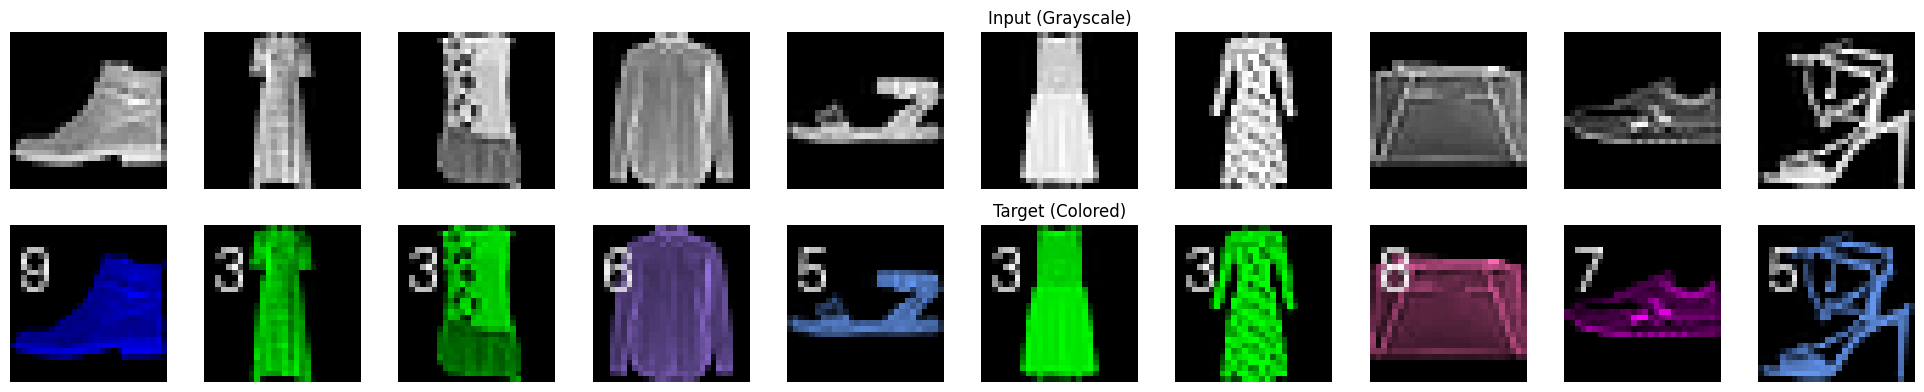

In [20]:
# utility function
def visualize_results(dataset, model=None, num_samples=10, log_to_wandb=False, epoch=0):
    """Show input/output examples in grid format"""
    inputs = torch.stack([dataset[i][0] for i in range(min(num_samples, len(dataset)))]).to(device)
    targets = torch.stack([dataset[i][1] for i in range(min(num_samples, len(dataset)))]).to(device)

    show_pred = model is not None
    if show_pred:
        with torch.no_grad():
            model.eval()
            preds = model(inputs)

    rows = 3 if show_pred else 2
    fig, axes = plt.subplots(rows, len(inputs), figsize=(2*len(inputs), 2*rows))
    if len(inputs) == 1: axes = axes.reshape(-1, 1)
    plt.subplots_adjust(left=0.02, right=0.98, top=0.92, bottom=0.08, wspace=0.05, hspace=0.4)

    titles = ['Input (Grayscale)', 'Target (Colored)'] + (['Prediction'] if show_pred else [])

    for i, (inp, tgt) in enumerate(zip(inputs.cpu(), targets.cpu())):
        axes[0,i].imshow(inp.squeeze(), cmap='gray'); axes[0,i].axis('off')
        axes[1,i].imshow(tgt.permute(1,2,0)); axes[1,i].axis('off')
        if show_pred:
            axes[2,i].imshow(preds[i].cpu().permute(1,2,0).clamp(0,1)); axes[2,i].axis('off')
        if i == len(inputs)//2:
            [axes[j,i].set_title(titles[j], fontsize=12) for j in range(rows)]

    plt.tight_layout(pad=1.0)
    (wandb.log({"Examples": wandb.Image(plt), "epoch": epoch+1}) if log_to_wandb else plt.show())
    plt.close()


print("\nSample data:")  # Show examples before training
visualize_results(val_dataset)

## U-Net Architecture

In [21]:
class DoubleConv(nn.Module):
    """Double convolution block used in U-Net"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
        # ConvTranspose2d can yield checkerboard artifacts. instead we'll do static upsampling + a conv.
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1)
        )
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)  # x1 from decoder path, x2 is skip connection from encoder
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)  # Concatenate skip connection (key U-Net feature!)
        return self.conv(x)

class UNet(nn.Module):
    """U-Net architecture with skip connections"""
    def __init__(self, n_channels=1, n_classes=3, features=[16, 32, 64, 128]): # features=[64, 128, 256, 512]) was overkill
        super().__init__()
        self.features = features

        self.inc = DoubleConv(n_channels, features[0])
        self.downs = nn.ModuleList([Down(features[i], features[i+1]) for i in range(len(features)-1)])
        self.ups = nn.ModuleList([Up(features[len(features)-1-i], features[len(features)-2-i]) for i in range(len(features)-1)])
        self.outc = nn.Conv2d(features[0], n_classes, 1)

    def forward(self, x):
        skip_connections = []
        x = self.inc(x)
        skip_connections.append(x)

        for down in self.downs:  # Downsampling path
            x = down(x)
            skip_connections.append(x)

        skip_connections = skip_connections[:-1]  # Remove last (bottleneck)

        for i, up in enumerate(self.ups):  # Upsampling path with skip connections
            skip = skip_connections[-(i+1)]
            x = up(x, skip)

        return torch.sigmoid(self.outc(x))

## Training Functions


In [22]:
def pixel_accuracy(pred, target, threshold=0.1):
    """Pixel-wise accuracy metric"""
    return ((pred - target).abs() < threshold).float().mean()


def log_example_images(model, inputs, targets, epoch, ncol=10):
    """Wrapper for wandb logging"""
    class TempDataset:
        def __init__(self, data):
            self.data = [(inputs[i].cpu(), targets[i].cpu()) for i in range(min(ncol, len(inputs)))]
        def __len__(self):
            return len(self.data)
        def __getitem__(self, idx):
            return self.data[idx]
    visualize_results(TempDataset([]), model=model, num_samples=ncol, log_to_wandb=True, epoch=epoch)


def train_unet(model, train_loader, val_loader, epochs=20, lr=1e-3):
    """Train the U-Net model"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    wandb.init(project="unet_fashion_mnist")
    wandb.config.update({"epochs": epochs, "lr": lr, "model": "UNet"})

    val_iter = iter(val_loader)  # Get fixed batch from validation set for consistent visualization
    fixed_batch = next(val_iter)
    fixed_inputs, fixed_targets = fixed_batch[0][:8].to(device), fixed_batch[1][:8].to(device)

    model.train()
    global_step = 0
    exp_beta = 0.97
    train_loss_avg = None

    for epoch in range(epochs):
        train_loss = train_acc = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += pixel_accuracy(output, target).item()

            # Log every step with exponential moving average
            train_loss_avg = loss.item() if train_loss_avg is None else train_loss_avg * exp_beta + loss.item() * (1 - exp_beta)
            wandb.log({ "step": global_step, "train_loss": train_loss_avg,  "epoch": epoch + 1 })

            global_step += 1
            pbar.set_postfix({'Train_Loss': f'{train_loss_avg:.4f}'})

        model.eval()  # Validation
        val_loss = val_acc = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                val_acc += pixel_accuracy(output, target).item()

        train_loss, train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
        val_loss, val_acc = val_loss/len(val_loader), val_acc/len(val_loader)

        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.3f}')
        print(f'           Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.3f}')

        if epoch % 1 == 0:  # Log example images every epoch
            log_example_images(model, fixed_inputs, fixed_targets, epoch)

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "lr": optimizer.param_groups[0]['lr']
        })

        model.train()

    wandb.finish()
    return model

## Main Execution


Model has 536,243 parameters

Starting training...


Epoch 1/15: 100%|██████████| 1750/1750 [00:33<00:00, 51.50it/s, Train_Loss=0.0119]


Epoch 1: Train Loss: 0.0211, Train Acc: 0.718
           Val Loss: 0.0124, Val Acc: 0.861


Epoch 2/15: 100%|██████████| 1750/1750 [00:34<00:00, 50.71it/s, Train_Loss=0.0094]


Epoch 2: Train Loss: 0.0106, Train Acc: 0.872
           Val Loss: 0.0102, Val Acc: 0.909


Epoch 3/15: 100%|██████████| 1750/1750 [00:34<00:00, 50.83it/s, Train_Loss=0.0097]


Epoch 3: Train Loss: 0.0091, Train Acc: 0.895
           Val Loss: 0.0086, Val Acc: 0.910


Epoch 4/15: 100%|██████████| 1750/1750 [00:33<00:00, 51.98it/s, Train_Loss=0.0086]


Epoch 4: Train Loss: 0.0084, Train Acc: 0.907
           Val Loss: 0.0082, Val Acc: 0.926


Epoch 5/15: 100%|██████████| 1750/1750 [00:34<00:00, 50.91it/s, Train_Loss=0.0085]


Epoch 5: Train Loss: 0.0079, Train Acc: 0.916
           Val Loss: 0.0084, Val Acc: 0.923


Epoch 6/15: 100%|██████████| 1750/1750 [00:34<00:00, 51.12it/s, Train_Loss=0.0079]


Epoch 6: Train Loss: 0.0074, Train Acc: 0.922
           Val Loss: 0.0079, Val Acc: 0.919


Epoch 7/15: 100%|██████████| 1750/1750 [00:33<00:00, 51.85it/s, Train_Loss=0.0075]


Epoch 7: Train Loss: 0.0072, Train Acc: 0.926
           Val Loss: 0.0084, Val Acc: 0.921


Epoch 8/15: 100%|██████████| 1750/1750 [00:33<00:00, 51.56it/s, Train_Loss=0.0074]


Epoch 8: Train Loss: 0.0068, Train Acc: 0.931
           Val Loss: 0.0080, Val Acc: 0.934


Epoch 9/15: 100%|██████████| 1750/1750 [00:33<00:00, 51.76it/s, Train_Loss=0.0062]


Epoch 9: Train Loss: 0.0067, Train Acc: 0.933
           Val Loss: 0.0071, Val Acc: 0.931


Epoch 10/15: 100%|██████████| 1750/1750 [00:34<00:00, 51.00it/s, Train_Loss=0.0062]


Epoch 10: Train Loss: 0.0064, Train Acc: 0.936
           Val Loss: 0.0067, Val Acc: 0.945


Epoch 11/15: 100%|██████████| 1750/1750 [00:34<00:00, 50.75it/s, Train_Loss=0.0061]


Epoch 11: Train Loss: 0.0062, Train Acc: 0.939
           Val Loss: 0.0069, Val Acc: 0.942


Epoch 12/15: 100%|██████████| 1750/1750 [00:34<00:00, 51.23it/s, Train_Loss=0.0059]


Epoch 12: Train Loss: 0.0061, Train Acc: 0.941
           Val Loss: 0.0068, Val Acc: 0.944


Epoch 13/15: 100%|██████████| 1750/1750 [00:33<00:00, 51.71it/s, Train_Loss=0.0055]


Epoch 13: Train Loss: 0.0059, Train Acc: 0.942
           Val Loss: 0.0067, Val Acc: 0.947


Epoch 14/15: 100%|██████████| 1750/1750 [00:33<00:00, 51.87it/s, Train_Loss=0.0056]


Epoch 14: Train Loss: 0.0058, Train Acc: 0.945
           Val Loss: 0.0066, Val Acc: 0.946


Epoch 15/15: 100%|██████████| 1750/1750 [00:34<00:00, 50.49it/s, Train_Loss=0.0063]


Epoch 15: Train Loss: 0.0057, Train Acc: 0.946
           Val Loss: 0.0073, Val Acc: 0.945


epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇████
train_acc,▁▆▆▇▇▇▇████████
train_loss,▇██▆▅▅▅▆▆█▅▄▅▄▄▄▅▅▃▂▄▄▄▄▃▁▂▂▃▃▃▁▂▂▃▄▂▁▂▂
val_acc,▁▅▅▆▆▆▆▇▇██████
val_loss,█▅▃▃▃▃▃▃▂▁▁▁▁▁▂
epoch,15
lr,0.001
step,26249
train_acc,0.94552



Results after training:


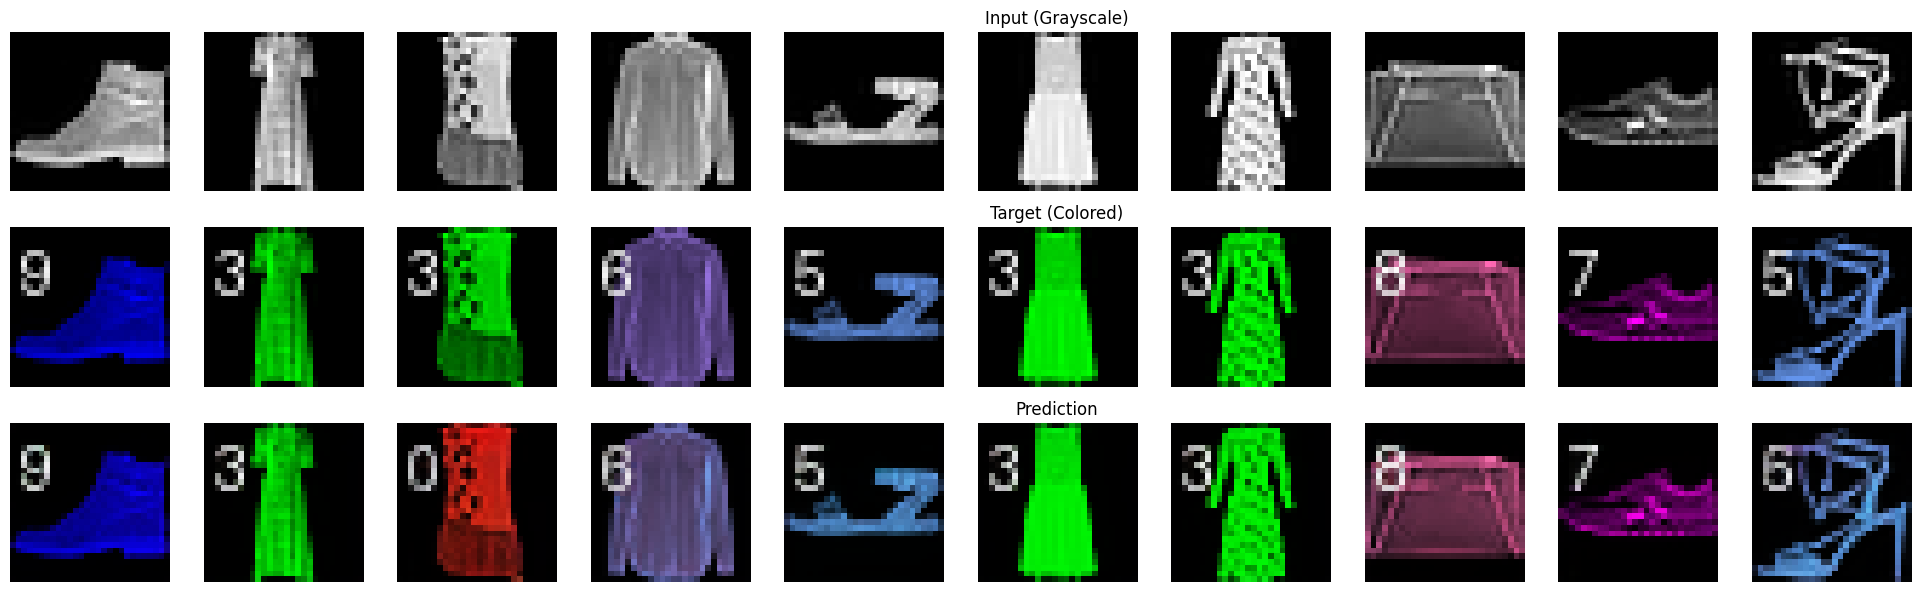

Model saved as 'unet_fashion_mnist.pth'


In [23]:

#DRAW_NUMBERS = True  # Configuration
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-3


# reproducible dataloaders
torch.manual_seed(42)
np.random.seed(42)
num_workers=0 # needed in jupyter, to avoid issues for now. =2 runs faster but not worth headaches rn
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)


model = UNet(n_channels=1, n_classes=3).to(device)  # Create model
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

print("\nStarting training...")  # Train the model
trained_model = train_unet(model, train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE)

print("\nResults after training:")  # Show results after training
visualize_results(val_dataset, trained_model)

torch.save(trained_model.state_dict(), 'unet_fashion_mnist.pth')  # Save the model
print("Model saved as 'unet_fashion_mnist.pth'")

...and we could keep training longer to see how much better we can do, but this is pretty good for now. ;-)

### More on U-Nets
U-Nets can useful for computing a variety of *changes* to images, audio, and other forms of data -- removing defects, filling in blanks, super-resolution.  Their efficient combination of multiresolution learning and computing changes (the concatenative skip connection can function as a "super residual" when combined with Linear layers) makes them a great choice.

 Though the U-Net is not a truly "generative" model - its outputs are determininistically dependent on the inputs. By injecting noise into the process in various ways, one can also use the U-Net to generate a variety of outputs.

# Summary and Moving On

The **lasting significance** of these models...

- Skip Connections: Residuals,  conncatenative skips and other variants are used in all models these days.  
- U-Nets have been part of generative models such as diffusion models, though they have been supplanted by a variant of Vision Transformers (ViT) namely Diffusion Transformers (DiT)  
- Somewhat related: The popular conditioning method known as FiLM ([paper](https://cdn.aaai.org/ojs/11671/11671-13-15199-1-2-20201228.pdf)) has [been shown to be a super-class](https://distill.pub/2018/feature-wise-transformations/) incorporating both residual and concatenative connections, though it is typically used to connected new inputs rather than disparate layers in a model.